## 1.6 Dropout

이번 실습에서는 Dropout에 대해서 알아보고자 합니다. Dropout은 대부분의 모델에서 사용할 수 있는 정규화 방법입니다. 

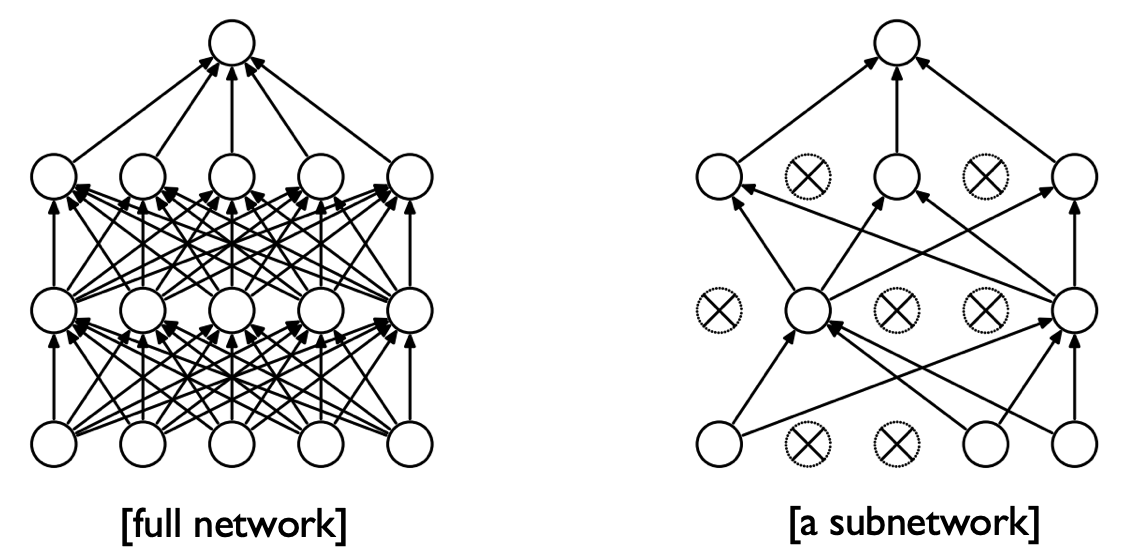

여러 개의 subnetworks를 앙상블하는 방법으로 해석할 수 있습니다. 

In [ ]:
import math
import random 

import tensorflow as tf
import numpy as np 

seed = 1
random.seed(seed)
np.random.seed(seed=seed)
tf.random.set_random_seed(seed)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape([-1, 28 * 28]) 
x_test = x_test.reshape([-1, 28 * 28])

m = np.random.randint(0, high=60000, size=1100, dtype=np.int64)
x_train = x_train[m]
y_train = y_train[m]

i = np.arange(1100)
np.random.shuffle(i)
x_train = x_train[i]
y_train = y_train[i]

x_valid = x_train[:100]
y_valid = y_train[:100]

x_train = x_train[100:]
y_train = y_train[100:]

x = tf.placeholder(tf.float32, [None, 28 * 28])
y = tf.placeholder(tf.int32, [None])
training = tf.placeholder(tf.bool)

n_units = [28 * 28, 512, 512, 10]

weights, biases = [], []
for i, (n_in, n_out) in enumerate(zip(n_units[:-1], n_units[1:])):
    stddev = math.sqrt(2 / n_in) # Kaiming He Initialization
    weight = tf.Variable(tf.random.truncated_normal([n_in, n_out], mean=0, stddev=stddev))
    bias = tf.Variable(tf.zeros([n_out]))
    weights.append(weight)
    biases.append(bias)

Dropout을 사용하기 위해서는 activation 이후에 dropout layer를 추가하면 됩니다. activation 전에하는 것보다 후에하는 것이 더 좋다고 알려져 있습니다. 

In [ ]:
layer = x 
for i, (weight, bias) in enumerate(zip(weights, biases)):
    layer = tf.matmul(layer, weight) + bias
    if i < len(weights) - 1:
        layer = tf.nn.tanh(layer)  
        layer = tf.layers.dropout(layer, rate=0.5, training=training)
y_hat = layer

다시 다른 부분들은 이전 실습과 동일하게 진행해 줍니다.

In [ ]:

y_hot = tf.one_hot(y, 10)
costs = tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=y_hot, logits=y_hat)
cross_entropy_loss = tf.reduce_mean(costs)
loss = cross_entropy_loss

accuracy = tf.count_nonzero(
        tf.cast(tf.equal(tf.argmax(y_hot, 1), tf.argmax(y_hat, 1)),
                tf.int64)) / tf.cast(tf.shape(y_hot)[0], tf.int64)

extra_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_ops):
    optimizer = tf.train.AdamOptimizer(1e-3)
    train_op = optimizer.minimize(loss)
    
gpu_options = tf.GPUOptions()
gpu_options.allow_growth = True
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
session.run(tf.global_variables_initializer())

max_valid_epoch_idx = 0
max_valid_accuracy = 0.0
final_test_accuracy = 0.0

import time 
times = []
for epoch_idx in range(1, 1000 + 1):
    start_time = time.time()
    session.run(
            train_op,
            feed_dict={
                x: x_train,
                y: y_train,
                training: True
            })
    times.append(time.time() - start_time)
    
    if epoch_idx % 10 == 0:
        train_loss_value, train_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_train,
                y: y_train,
                training: False
            })
        
        valid_loss_value, valid_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_valid,
                y: y_valid,
                training: False
            })
            
        test_loss_value, test_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_test,
                y: y_test,
                training: False
            })

        print(epoch_idx, '%.4f' % train_loss_value, '%.4f' % valid_loss_value, '%.4f' % test_loss_value, '%.4f' % train_accuracy_value, '%.4f' % valid_accuracy_value, '%.4f' % test_accuracy_value)
        
        if max_valid_accuracy < valid_accuracy_value:
            max_valid_accuracy = valid_accuracy_value 
            max_valid_epoch_idx = epoch_idx
            final_test_accuracy = test_accuracy_value
            
    # Early Stop
    if max_valid_epoch_idx + 100 < epoch_idx:
        break
        
print(final_test_accuracy)
print(sum(times) / len(times))

88.05% -> 89.3% 성능이 향상됨을 확인할 수 있습니다. 

### 연습문제

Q1. Dropout Rate을 바꿔가면서 성능을 확인해봅시다. 

Q2. tf.nn.dropout를 이용해서 dropout을 다시 구현해봅시다. tf.layers.dropout을 사용할 때와 비슷한 성능이 나오나요?
(참고: [API 문서](https://www.tensorflow.org/api_docs/python/tf/nn/dropout))
([여기](01_06_dropout_Q2_answer.txt)에서 정답을 확인할 수 있습니다.)

Q3. [tf.layers.dropout API 문서](https://www.tensorflow.org/api_docs/python/tf/layers/dropout)에 보면 다음과 같은 서술이 있습니다.
```
The units that are kept are scaled by 1 / (1 - rate)
```
이 구현이 왜 필요한지 생각해봅시다.

Q4. tf.keras.layers.GaussianDropout를 이용해 Gaussian Dropout을 구현해봅시다. 더 빠른 수렴이 가능해 지나요? Gaussian Dropout에 대해서도 dropout rate을 변경해보면서 성능 그래프를 그려봅시다. 
(정답은 [여기](01_06_dropout_Q4_answer.txt)에서 확인할 수 있습니다.)

Q5. (도전과제) DropConnect를 구현해보고, Dropout보다 성능이 실제 증가하는지 확인해봅시다. 

주의사항! 코드를 수정한 이후에는 Kernel > Restart & Run All 을 통해 네트워크를 처음부터 다시 학습시켜 주세요. 

### 다음 실습 

이제 다음 [실습](01_07_augmentation.ipynb)에서는 Augmentation을 적용하는 방법에 대해 알아보도록 하겠습니다. 